# Предварительный анализ данных и построение признаков в задачах идентификации личности по голосу    
**Выполнил**: Карымов Игорь   
**Группа**: ПМ22-7

## Импорт библиотек

In [589]:
from datasets import load_dataset
from librosa.feature import mfcc, spectral_centroid, spectral_rolloff, zero_crossing_rate
from librosa.feature import rms, spectral_bandwidth, spectral_contrast, spectral_flatness, poly_features
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import make_pipeline
import pandas as pd
from librosa import lpc
import librosa
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from time import time
import scipy

## Загрузка датасета с Hugging Face

In [6]:
dataset = load_dataset("librispeech_asr", trust_remote_code=True, streaming=True, split='test.clean')

### Краткое описание датасета    
LibriSpeech - это корпус из примерно 1000 часов английской речи с частотой чтения 16 кГц, подготовленный Василием Панайотовым при содействии Дэниела Пови. Данные взяты из прочитанных аудиокниг проекта LibriVox и были тщательно сегментированы и выровнены.    

Поля данных        
file: путь к загруженному аудиофайлу в формате .flac    
audio: словарь, содержащий путь к загруженному аудиофайлу, расшифрованный аудиоматериал и частоту дискретизации     
text: транскрипция аудиофайла    
id: уникальный идентификатор выборки данных    
speaker_id: уникальный идентификатор говорящего     
chapter_id: идентификатор главы аудиокниги, которая содержит транскрипцию    

## Предварительный анализ данных

Преобразование датасета в датафрейм

In [7]:
DF = pd.DataFrame(dataset)

Создание резервной копии датафрейма

In [219]:
df = DF.copy()

Удаление ненужных признаков и переименование оставшихся

In [220]:
df = pd.concat([df,df.audio.apply(pd.Series)],axis=1).drop(['file', 'text', 'chapter_id', 'id', 'path', 'audio'],axis=1)
df.columns = ['speaker_id', 'audio_array', 'sampling_rate']
df.head()

,speaker_id,audio_array,sampling_rate
0,6930,"[-6.103515625e-05, 9.1552734375e-05, 0.0010681...",16000
1,6930,"[-0.005706787109375, -0.00732421875, 0.0051269...",16000
2,6930,"[0.00091552734375, 0.00115966796875, 0.0010375...",16000
3,6930,"[0.003265380859375, -0.002777099609375, -0.001...",16000
4,6930,"[-0.008819580078125, -0.001983642578125, 0.005...",16000


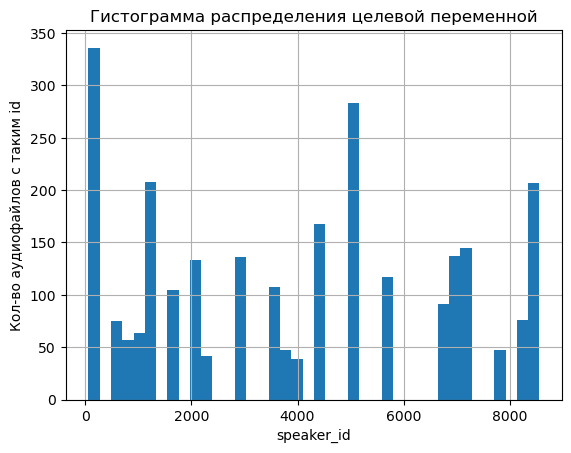

In [551]:
df.speaker_id.hist(bins=len(df.speaker_id.unique()))
plt.title('Гистограмма распределения целевой переменной')
plt.ylabel('Кол-во аудиофайлов с таким id')
plt.xlabel('speaker_id')
plt.show()

### Наблюдается дисбаланс классов, поэтому для оценки моделей буду использовать взвешенный f1, так как эта метрика рассчитывает f1 для каждого класса и находит их среднее значение, взвешенное по количеству истинных экземпляров для каждой класса.

## Построение признаков

### Мел-частотные кепстральные коэффициенты    
Учёные выяснили, что человек воспринимает частоты звука по-разному. Низкие частоты более значимы для нас, высокие – менее значимы.    

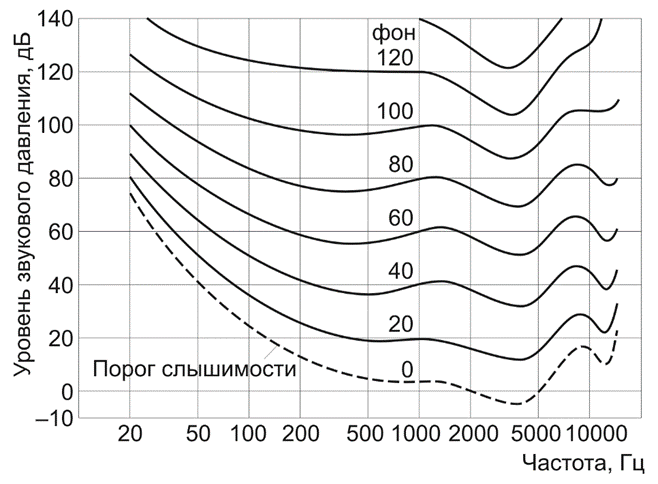

Нелинейная шкала, показывающая значимость частот звука для человека, называется мел-шкалой.    
Значения из герц в значения мел-шкалы могут быть пересчитаны по простой формуле:

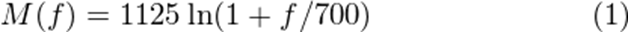

In [567]:
signal = df.audio_array[0]

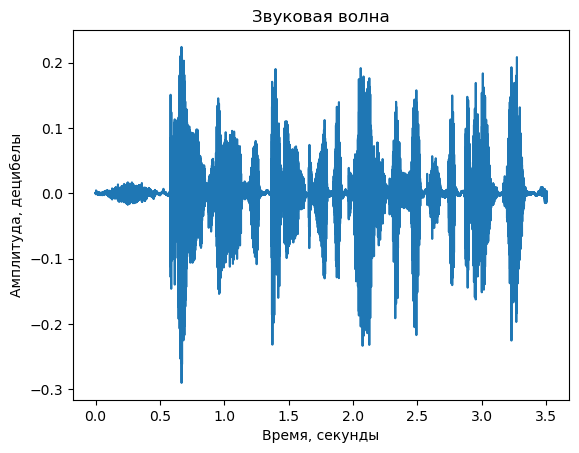

In [568]:
y = signal
x = np.arange(len(y))/16000
plt.title('Звуковая волна')
plt.ylabel('Амплитуда, децибелы')
plt.xlabel('Время, секунды')
plt.plot(x, y)
plt.show()

Text(0, 0.5, 'Amplitude')

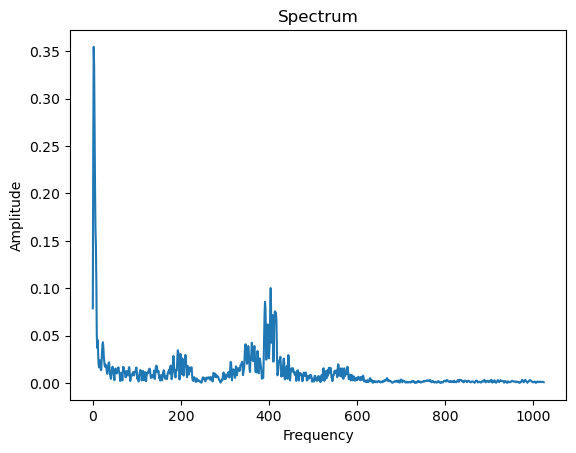

In [570]:
n_fft = 2048
ft = np.abs(librosa.stft(signal[:n_fft], hop_length = n_fft+1))
plt.plot(ft)
plt.title('Spectrum')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')

На спектрограмме видно, что основная информация собрана в области низких и средних частот.

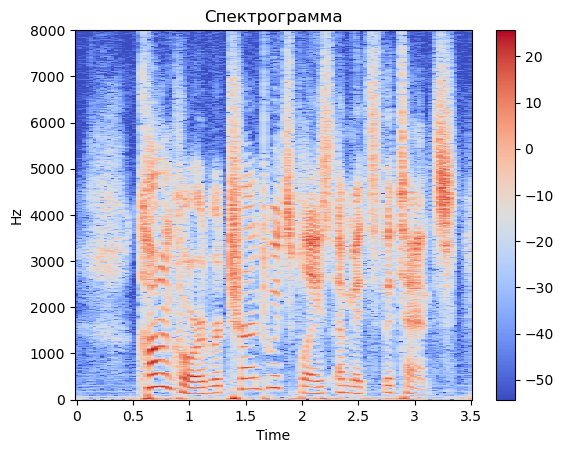

In [571]:
X = librosa.stft(signal)
s = librosa.amplitude_to_db(abs(X))
librosa.display.specshow(s, sr=16000, x_axis = 'time', y_axis='linear')
plt.colorbar()
plt.title('Спектрограмма')
plt.show()

#### Мел-кепcтральные коэффициенты (MFCC) являются одним из важнейших признаков в обработке аудио. Процесс вычисления данных коэффициентов учитывает ряд особенностей слухового анализатора человека, моделируя характеристики человеческого голоса.  Это связано с тем, что звуки, воспроизводимые человеком, определяется формой голосового тракта, включая язык, зубы и т.д.

In [221]:
def mfcc_(batch, n):
    audio_array = batch['audio_array']
    rate = batch['sampling_rate']
    mfccs = mfcc(y=audio_array, sr=rate, n_mfcc=n)
    mfcc_mean = mfccs.mean(axis=1)
    mfcc_std = mfccs.std(axis=1)
    return mfcc_mean, mfcc_std
    
def add_mfcc(df, n=13):
    mean_std_df = df.apply(lambda x: mfcc_(x, n=n), axis=1).apply(pd.Series)
    mfcc_mean_df = mean_std_df[0].apply(pd.Series)
    mfcc_mean_df.columns = [f'mfcc_mean_{n}' for n in range(1, n+1)]
    mfcc_std_df = mean_std_df[1].apply(pd.Series)
    mfcc_std_df.columns = [f'mfcc_std_{n}' for n in range(1, n+1)]
    return pd.concat([mfcc_mean_df, mfcc_std_df],axis=1)

In [16]:
mfcc_df = add_mfcc(df)

In [17]:
mfcc_df.head()

,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,mfcc_mean_9,mfcc_mean_10,...,mfcc_std_4,mfcc_std_5,mfcc_std_6,mfcc_std_7,mfcc_std_8,mfcc_std_9,mfcc_std_10,mfcc_std_11,mfcc_std_12,mfcc_std_13
0,-305.636781,14.479371,-13.723803,57.836967,-30.683759,28.041073,-12.865450,-4.944065,2.266993,7.818210,...,25.333528,19.481001,17.242129,16.973762,17.490482,11.757950,15.368954,7.701847,10.728212,12.094657
1,-270.185502,18.394196,-17.689889,72.626128,-32.793131,17.094750,-12.735961,-6.703136,2.268759,1.989206,...,29.373098,20.711823,16.682346,15.949933,14.122995,11.561662,16.334057,11.674498,10.369921,11.110519
2,-274.003011,36.557182,-27.480394,65.777843,-34.162856,18.018577,-18.948340,-7.260567,2.555662,1.876616,...,29.674870,22.430603,20.739138,20.126257,16.413892,13.134560,14.343244,12.082557,9.446889,9.693210
3,-268.464424,15.854851,-20.815412,74.652523,-34.421598,15.651378,-10.870236,-4.552543,1.434747,1.765074,...,32.929575,22.647978,17.112111,16.949865,15.601367,11.866091,15.453124,11.190739,10.526851,10.953408
4,-284.458395,35.075027,-27.258638,65.960125,-34.337090,19.049896,-12.060438,-6.349278,3.859591,4.988733,...,31.868909,24.979401,14.785186,17.512498,15.618419,10.895835,14.860691,9.987701,8.646317,10.331254


#### Спектральный центроид (Spectral Centroid) является хорошим показателем яркости звука, широко используется в качестве автоматической меры музыкального тембра. То есть центроид показывает где расположен центр масс звука.

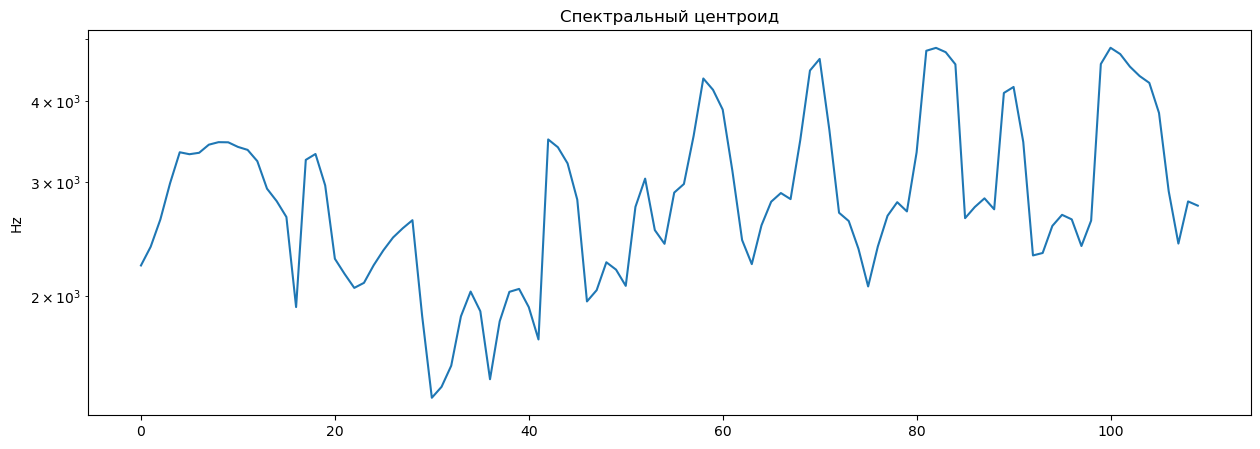

In [577]:
cent = librosa.feature.spectral_centroid(y=signal, sr=16000)
plt.figure(figsize=(15,5))
plt.title('Спектральный центроид')
plt.semilogy(cent.T)
plt.ylabel('Hz')
plt.show()

In [21]:
def cent_(batch):
    audio_array = batch['audio_array']
    rate = batch['sampling_rate']
    cent = spectral_centroid(y=audio_array, sr=rate)
    cent_mean = cent.mean()
    cent_std = cent.std()
    return cent_mean, cent_std

def add_cent(df):
    cent_df = df.apply(lambda x: cent_(x), axis=1).apply(pd.Series)
    cent_df.columns = ['cent_mean', 'cent_std']
    return cent_df

In [22]:
cent_df = add_cent(df)

In [23]:
cent_df.head()

,cent_mean,cent_std
0,2911.036723,847.354649
1,2774.853397,704.183123
2,2532.499758,654.949204
3,2782.365751,697.146971
4,2567.749234,688.129412


#### Спектральный спад  (Spectral Rolloff) представляет собой частоту, ниже которой лежит определенный процент от общей спектральной энергии.

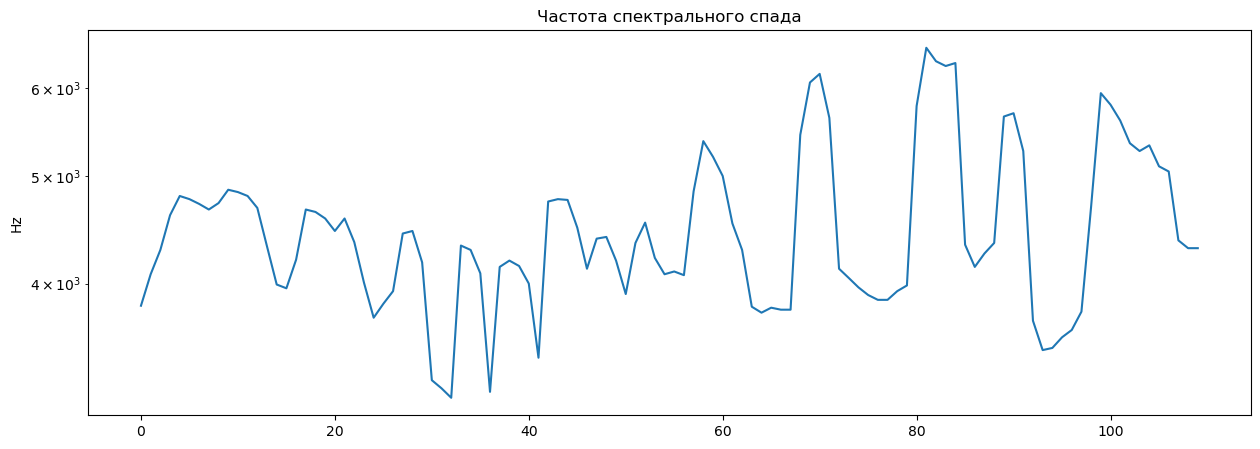

In [576]:
rolloff = librosa.feature.spectral_rolloff(y=signal, sr=16000)
plt.figure(figsize=(15,5))
plt.title('Частота спектрального спада')
plt.semilogy(rolloff.T)
plt.ylabel('Hz')
plt.show()

In [26]:
def rolloff_(batch):
    audio_array = batch['audio_array']
    rate = batch['sampling_rate']
    rolloff = spectral_rolloff(y=audio_array, sr=rate)
    rolloff_mean = rolloff.mean()
    rolloff_std = rolloff.std()
    return rolloff_mean, rolloff_std

def add_rolloff(df):
    rolloff_df = df.apply(lambda x: rolloff_(x), axis=1).apply(pd.Series)
    rolloff_df.columns = ['rolloff_mean', 'rolloff_std']
    return rolloff_df

In [27]:
rolloff_df = add_rolloff(df)

In [28]:
rolloff_df.head()

,rolloff_mean,rolloff_std
0,4487.073864,736.314560
1,4269.768258,630.693741
2,4086.234177,647.678614
3,4243.752143,632.728729
4,4137.870303,636.076294


#### Скорость пересечения нуля (Zero crossing Rate) является частотой изменения знака сигнала, то есть частота, с которой сигнал меняется с положительного на отрицательный и обратно.

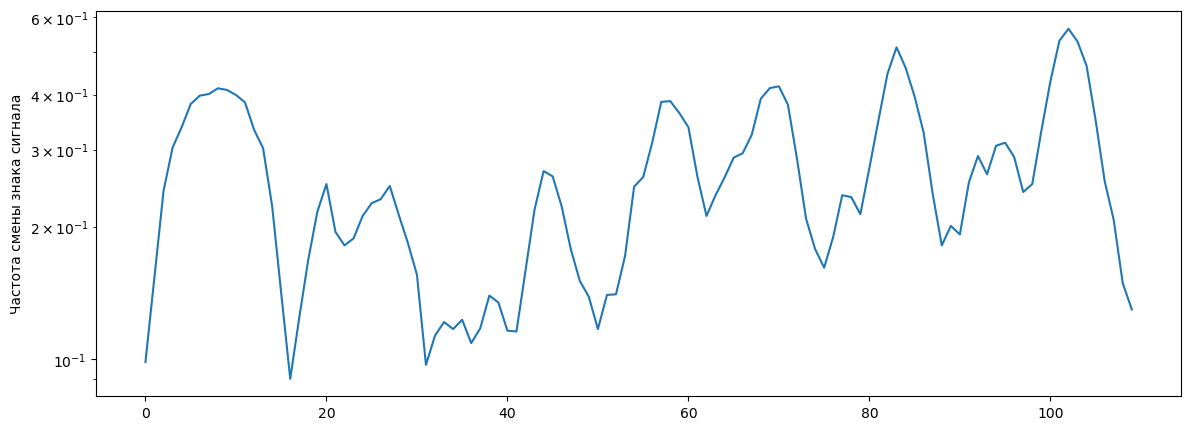

In [580]:
zrate=librosa.feature.zero_crossing_rate(signal)
plt.figure(figsize=(14,5))
plt.semilogy(zrate.T)
plt.ylabel('Частота смены знака сигнала')
plt.show()

In [31]:
def zrate_(batch):
    audio_array = batch['audio_array']
    zrate = zero_crossing_rate(audio_array)
    zrate_mean = zrate.mean()
    zrate_std = zrate.std()
    return zrate_mean, zrate_std

def add_zrate(df):
    zrate_df = df.apply(lambda x: zrate_(x), axis=1).apply(pd.Series)
    zrate_df.columns = ['zrate_mean', 'zrate_std']
    return zrate_df

In [32]:
zrate_df = add_zrate(df)

In [33]:
zrate_df.head()

,zrate_mean,zrate_std
0,0.258909,0.110258
1,0.252216,0.098620
2,0.219340,0.078044
3,0.257601,0.098912
4,0.227347,0.101990


#### RMS -  среднеквадратичное значение энергии звука

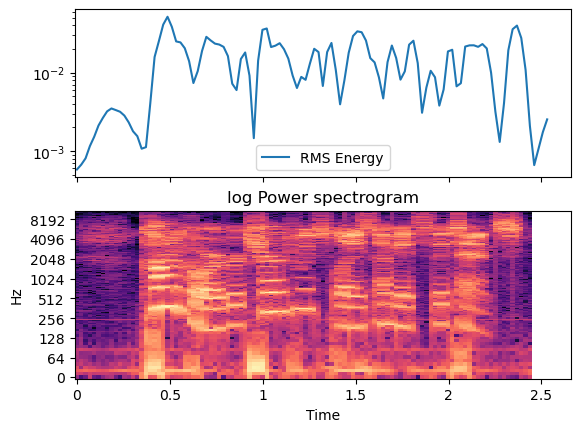

In [585]:
y = signal

S, phase = librosa.magphase(librosa.stft(y))
rms = librosa.feature.rms(S=S)

fig, ax = plt.subplots(nrows=2, sharex=True)
times = librosa.times_like(rms)
ax[0].semilogy(times, rms[0], label='RMS Energy')
ax[0].set(xticks=[])
ax[0].legend()
ax[0].label_outer()
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='log', x_axis='time', ax=ax[1])
ax[1].set(title='log Power spectrogram')
S = librosa.magphase(librosa.stft(y, window=np.ones, center=False))[0]
librosa.feature.rms(S=S)
plt.show()

In [382]:
def rms_(batch):
    audio_array = batch['audio_array']
    rmss = rms(y=audio_array)
    rms_mean = rmss.mean()
    rms_std = rmss.std()
    return rms_mean, rms_std

def add_rms(df):
    rms_df = df.apply(lambda x: rms_(x), axis=1).apply(pd.Series)
    rms_df.columns = ['rms_mean', 'rms_std']
    return rms_df

In [383]:
rms_df = add_rms(df)

In [384]:
rms_df.head()

,rms_mean,rms_std
0,0.024830,0.015550
1,0.032840,0.020094
2,0.031552,0.021471
3,0.035722,0.022524
4,0.029762,0.019448


#### Bandwidth - ширина канала основной частоты

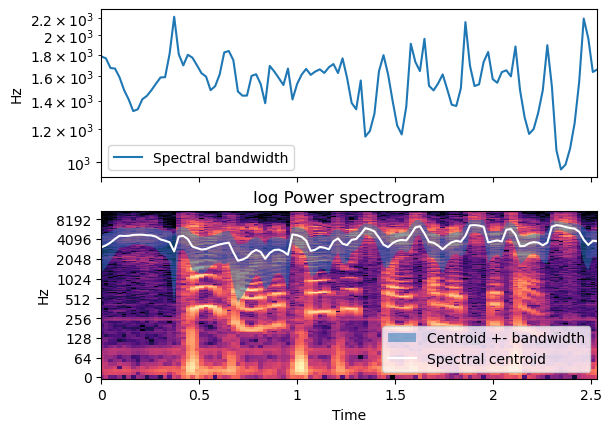

In [588]:
y, sr = signal, 16000
spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)

S, phase = librosa.magphase(librosa.stft(y=y))

freqs, times, D = librosa.reassigned_spectrogram(y, fill_nan=True)

fig, ax = plt.subplots(nrows=2, sharex=True)
times = librosa.times_like(spec_bw)
centroid = librosa.feature.spectral_centroid(S=S)
ax[0].semilogy(times, spec_bw[0], label='Spectral bandwidth')
ax[0].set(ylabel='Hz', xticks=[], xlim=[times.min(), times.max()])
ax[0].legend()
ax[0].label_outer()
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='log', x_axis='time', ax=ax[1])
ax[1].set(title='log Power spectrogram')
ax[1].fill_between(times, np.maximum(0, centroid[0] - spec_bw[0]),
                np.minimum(centroid[0] + spec_bw[0], sr/2),
                alpha=0.5, label='Centroid +- bandwidth')
ax[1].plot(times, centroid[0], label='Spectral centroid', color='w')
ax[1].legend(loc='lower right')

plt.show()

In [385]:
def bandw_(batch):
    audio_array = batch['audio_array']
    rate = batch['sampling_rate']
    bandw = spectral_bandwidth(y=audio_array, sr=rate)
    bandw_mean = bandw.mean()
    bandw_std = bandw.std()
    return bandw_mean, bandw_std

def add_bandw(df):
    bandw_df = df.apply(lambda x: bandw_(x), axis=1).apply(pd.Series)
    bandw_df.columns = ['bandw_mean', 'bandw_std']
    return bandw_df

In [386]:
bandw_df = add_bandw(df)

In [387]:
bandw_df.head()

,bandw_mean,bandw_std
0,1564.623452,227.840626
1,1521.264804,238.676481
2,1511.820350,216.952425
3,1484.925159,261.032028
4,1517.668905,249.150121


#### Спектральная плоскостность (flatness) (или коэффициент тональности) - это показатель, позволяющий количественно оценить, насколько звук похож на шум, в отличие от звука, подобного тону 1. Высокая спектральная плоскостность (ближе к 1.0) указывает на то, что спектр похож на белый шум.

In [388]:
def flatn_(batch):
    audio_array = batch['audio_array']
    flatn = spectral_flatness(y=audio_array)
    flatn_mean = flatn.mean()
    flatn_std = flatn.std()
    return flatn_mean, flatn_std

def add_flatn(df):
    flatn_df = df.apply(lambda x: flatn_(x), axis=1).apply(pd.Series)
    flatn_df.columns = ['flatn_mean', 'flatn_std']
    return flatn_df

In [389]:
flatn_df = add_flatn(df)

In [390]:
flatn_df.head()

,flatn_mean,flatn_std
0,0.052220,0.048492
1,0.039252,0.043294
2,0.030346,0.028399
3,0.038985,0.044058
4,0.037991,0.046419


#### Коэффициенты линейного прогнозирования по методу Бурга (LPC)    
#### Метод Бурга для оценки коэффициентов линейного фильтра по амплитуде звуковой волны определённого порядка.
Учёные выяснили, что оптимальным значением порядка является 7

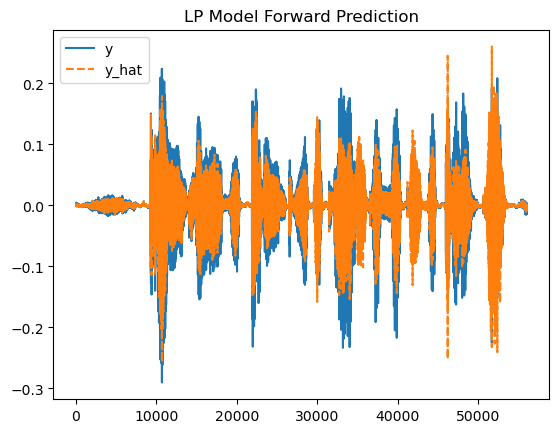

In [591]:
y, sr = signal, 16000
a = librosa.lpc(y, order=7)
b = np.hstack([[0], -1 * a[1:]])
y_hat = scipy.signal.lfilter(b, [1], y)
fig, ax = plt.subplots()
ax.plot(y)
ax.plot(y_hat, linestyle='--')
ax.legend(['y', 'y_hat'])
ax.set_title('LP Model Forward Prediction')
plt.show()

In [341]:
def lpc_(batch, order):
    audio_array = batch['audio_array']
    return lpc(audio_array, order=order)

def add_lpc(df, order=7):
    lpc_df = df.apply(lambda x: lpc_(x, order=order), axis=1).apply(pd.Series)
    lpc_df.columns = [f'lpc_coef_{n}' for n in range(1, order+2)]
    return lpc_df

In [342]:
lpc_df = add_lpc(df)

In [357]:
lpc_df.head()

,lpc_coef_1,lpc_coef_2,lpc_coef_3,lpc_coef_4,lpc_coef_5,lpc_coef_6,lpc_coef_7,lpc_coef_8
0,1.0,-1.178679,1.319581,-1.349910,0.812573,-0.558643,0.241072,0.005350
1,1.0,-1.319625,1.747925,-1.620673,1.021980,-0.713522,0.223582,-0.085034
2,1.0,-1.612356,2.111554,-2.031302,1.394048,-0.874367,0.312188,-0.087194
3,1.0,-1.242718,1.684677,-1.521163,0.984307,-0.724478,0.235270,-0.152523
4,1.0,-1.561243,1.990344,-1.960501,1.296309,-0.783409,0.308962,-0.041209


#### Cпектральный контраст

Каждый кадр спектрограммы делится на поддиапазоны. Для каждого поддиапазона энергетический контраст оценивается путем сравнения средней энергии в верхнем квантиле (пиковая энергия) с энергией в нижнем квантиле (энергия понижения). Высокие значения контрастности обычно соответствуют четким узкополосным сигналам, в то время как низкие значения контрастности соответствуют широкополосному шуму.

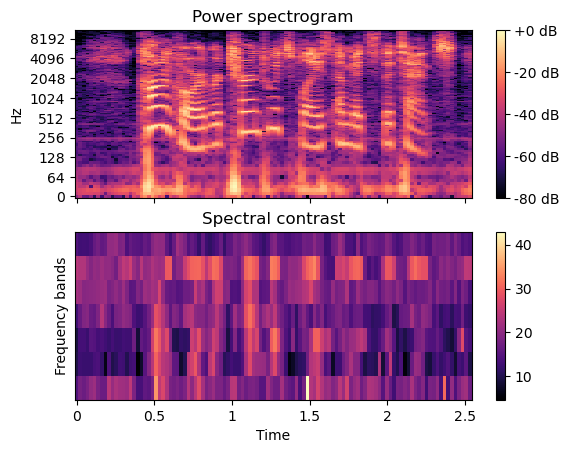

In [592]:
y, sr = signal, 16000
S = np.abs(librosa.stft(y))
contrast = librosa.feature.spectral_contrast(S=S, sr=sr)

fig, ax = plt.subplots(nrows=2, sharex=True)
img1 = librosa.display.specshow(librosa.amplitude_to_db(S,
                                                 ref=np.max),
                         y_axis='log', x_axis='time', ax=ax[0])
fig.colorbar(img1, ax=[ax[0]], format='%+2.0f dB')
ax[0].set(title='Power spectrogram')
ax[0].label_outer()
img2 = librosa.display.specshow(contrast, x_axis='time', ax=ax[1])
fig.colorbar(img2, ax=[ax[1]])
ax[1].set(ylabel='Frequency bands', title='Spectral contrast')

plt.show()

In [396]:
def contr_(batch):
    audio_array = batch['audio_array']
    rate = batch['sampling_rate']
    contr = spectral_contrast(y=audio_array, sr=rate)
    contr_mean = contr.mean(axis=1)
    contr_std = contr.std(axis=1)
    return contr_mean, contr_std
    
def add_contr(df):
    mean_std_df = df.apply(lambda x: contr_(x), axis=1).apply(pd.Series)
    contr_mean_df = mean_std_df[0].apply(pd.Series)
    contr_mean_df.columns = [f'contr_mean_{n}' for n in range(1, 8)]
    contr_std_df = mean_std_df[1].apply(pd.Series)
    contr_std_df.columns = [f'contr_std_{n}' for n in range(1, 8)]
    return pd.concat([contr_mean_df, contr_std_df],axis=1)

In [397]:
contr_df = add_contr(df)

In [398]:
contr_df.head()

,contr_mean_1,contr_mean_2,contr_mean_3,contr_mean_4,contr_mean_5,contr_mean_6,contr_mean_7,contr_std_1,contr_std_2,contr_std_3,contr_std_4,contr_std_5,contr_std_6,contr_std_7
0,19.731658,15.585123,17.603442,17.569711,19.130099,23.100519,16.163335,4.354121,6.022160,6.062339,4.239563,3.149276,5.351924,2.435104
1,20.774353,17.300934,19.207984,17.127719,18.782753,24.579522,16.436867,4.349206,6.087108,6.264052,4.059590,3.790143,5.311837,2.421575
2,20.923038,18.764349,20.125659,18.143710,18.958733,24.902965,16.107163,5.441355,6.885992,6.251500,3.992944,3.145169,4.517289,2.379825
3,20.277350,17.265442,19.042614,17.298388,19.189308,24.550168,16.022646,4.608927,6.447172,6.049362,3.899260,3.850191,5.301509,2.427465
4,20.285608,17.106329,19.152660,17.762084,18.629325,24.841702,15.945746,4.628329,6.690154,6.289674,4.140550,3.536607,5.334424,2.548299


#### Коэффициенты подгонки полинома n-го порядка к столбцам спектрограммы.

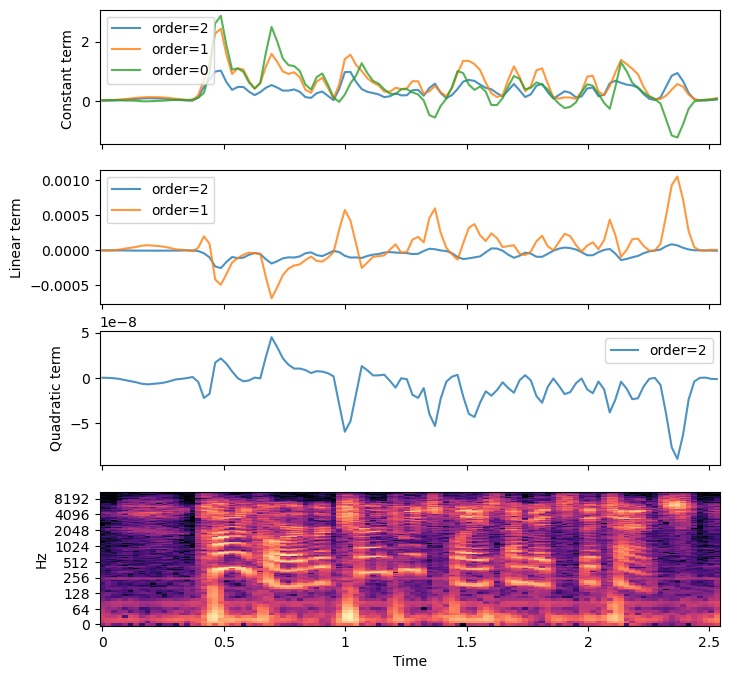

In [633]:
y, sr = signal, 16000
S = np.abs(librosa.stft(y))

p0 = librosa.feature.poly_features(S=S, order=0)
p1 = librosa.feature.poly_features(S=S, order=1)
p2 = librosa.feature.poly_features(S=S, order=2)

fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(8, 8))
times = librosa.times_like(p0)
ax[0].plot(times, p0[0], label='order=2', alpha=0.8)
ax[0].plot(times, p1[1], label='order=1', alpha=0.8)
ax[0].plot(times, p2[2], label='order=0', alpha=0.8)
ax[0].legend()
ax[0].label_outer()
ax[0].set(ylabel='Constant term ')
ax[1].plot(times, p1[0], label='order=2', alpha=0.8)
ax[1].plot(times, p2[1], label='order=1', alpha=0.8)
ax[1].set(ylabel='Linear term')
ax[1].label_outer()
ax[1].legend()
ax[2].plot(times, p2[0], label='order=2', alpha=0.8)
ax[2].set(ylabel='Quadratic term')
ax[2].legend()
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='log', x_axis='time', ax=ax[3])

plt.show()

In [401]:
def poly_(batch):
    audio_array = batch['audio_array']
    rate = batch['sampling_rate']
    poly = poly_features(y=audio_array, sr=rate)
    poly_mean = poly.mean(axis=1)
    poly_std = poly.std(axis=1)
    return poly_mean, poly_std
    
def add_poly(df):
    mean_std_df = df.apply(lambda x: poly_(x), axis=1).apply(pd.Series)
    poly_mean_df = mean_std_df[0].apply(pd.Series)
    poly_mean_df.columns = [f'poly_mean_{n}' for n in range(1, 3)]
    poly_std_df = mean_std_df[1].apply(pd.Series)
    poly_std_df.columns = [f'poly_std_{n}' for n in range(1, 3)]
    return pd.concat([poly_mean_df, poly_std_df],axis=1)

In [402]:
poly_df = add_poly(df)

In [403]:
poly_df.head()

,poly_mean_1,poly_mean_2,poly_std_1,poly_std_2
0,-0.000063,0.575720,0.000081,0.501854
1,-0.000085,0.775734,0.000073,0.564498
2,-0.000101,0.817846,0.000082,0.651672
3,-0.000089,0.836493,0.000078,0.604869
4,-0.000093,0.757295,0.000085,0.609486


Объединение всех признаков в один датафрейм

In [404]:
df_with_f = pd.concat([df,
                       mfcc_df,
                       cent_df,
                       rolloff_df,
                       zrate_df,
                       lpc_df,
                       rms_df,
                       bandw_df,
                       flatn_df,
                       contr_df,
                       poly_df
                      ],axis=1).drop(['audio_array', 'sampling_rate'], axis=1)

In [405]:
df_with_f.head()

,speaker_id,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,mfcc_mean_9,...,contr_std_2,contr_std_3,contr_std_4,contr_std_5,contr_std_6,contr_std_7,poly_mean_1,poly_mean_2,poly_std_1,poly_std_2
0,6930,-305.636781,14.479371,-13.723803,57.836967,-30.683759,28.041073,-12.865450,-4.944065,2.266993,...,6.022160,6.062339,4.239563,3.149276,5.351924,2.435104,-0.000063,0.575720,0.000081,0.501854
1,6930,-270.185502,18.394196,-17.689889,72.626128,-32.793131,17.094750,-12.735961,-6.703136,2.268759,...,6.087108,6.264052,4.059590,3.790143,5.311837,2.421575,-0.000085,0.775734,0.000073,0.564498
2,6930,-274.003011,36.557182,-27.480394,65.777843,-34.162856,18.018577,-18.948340,-7.260567,2.555662,...,6.885992,6.251500,3.992944,3.145169,4.517289,2.379825,-0.000101,0.817846,0.000082,0.651672
3,6930,-268.464424,15.854851,-20.815412,74.652523,-34.421598,15.651378,-10.870236,-4.552543,1.434747,...,6.447172,6.049362,3.899260,3.850191,5.301509,2.427465,-0.000089,0.836493,0.000078,0.604869
4,6930,-284.458395,35.075027,-27.258638,65.960125,-34.337090,19.049896,-12.060438,-6.349278,3.859591,...,6.690154,6.289674,4.140550,3.536607,5.334424,2.548299,-0.000093,0.757295,0.000085,0.609486


Отделение целевого признака

In [406]:
y = df_with_f.speaker_id
X = df_with_f.drop('speaker_id', axis=1)

## Построение модели и оценка значимости признаков

Буду строить модель классификации на основе линейного метода опорных векторов, так как, не из моделей глубокого машинного обучения, она используется чаще всего для идентификации личности по голосу.

Перед обучением модели стандартизирую все признаки, так как SVM модели очень чувствительны к разным порядкам признаков, но более того это поможет мне оценить значимость признаков на основе их коэффициентов в модели.

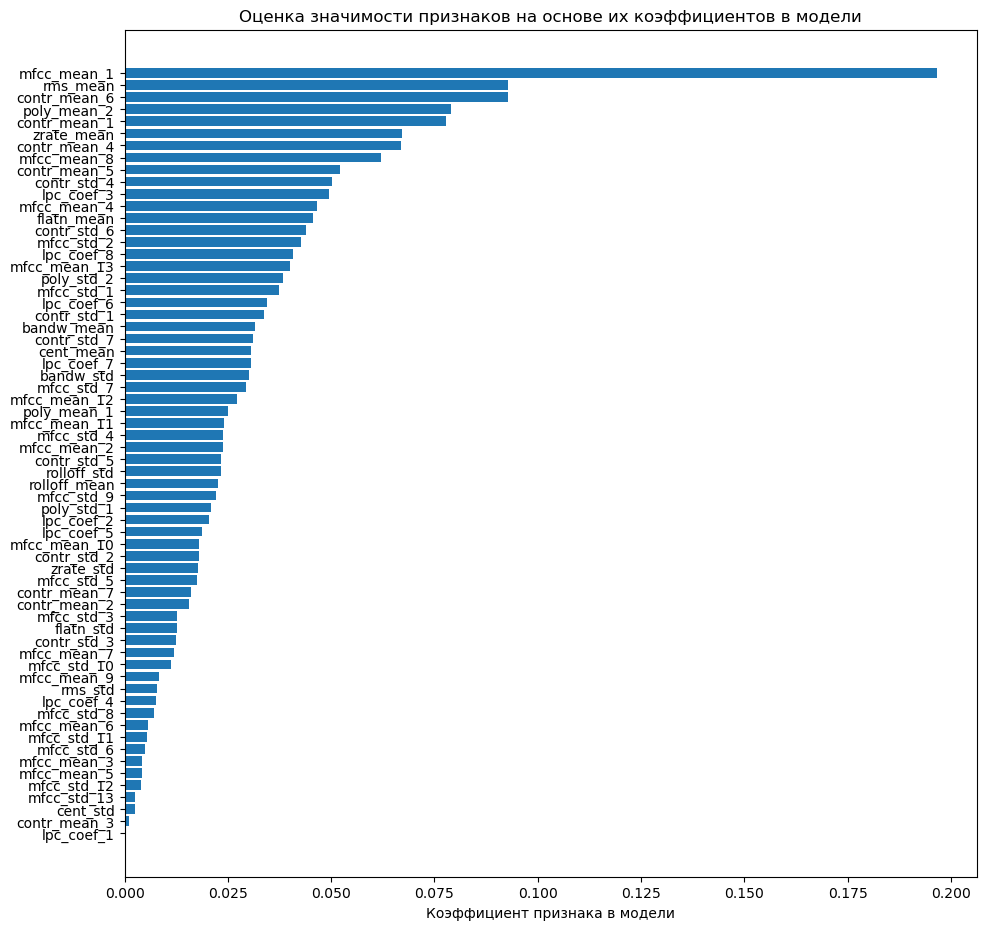

In [608]:
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp, names)))
    fig, ax = plt.subplots(figsize=(11,11))
    ax.barh(range(len(names)), imp, align='center')
    plt.title('Оценка значимости признаков на основе их коэффициентов в модели')
    plt.xlabel('Коэффициент признака в модели')
    plt.yticks(range(len(names)), names)
    plt.show()

features_names = X.columns.to_list()
clf = make_pipeline(StandardScaler(), LinearSVC(max_iter=10000))
clf.fit(X, y)
f_importances(abs(clf.get_params()['linearsvc'].coef_.mean(axis=0)), features_names)

### Значимости признаков для модели очень сильно отличаются, поэтому будем проводить отбор признаков на основе того, насколько улучшается метрика f1_weighted модели при добавлении нового признака. 

Отсортируем признаки по их значимости для модели

In [609]:
imp = pd.Series(*zip(*sorted(zip(abs(clf.get_params()['linearsvc'].coef_.mean(axis=0)), features_names), reverse=True)))
imp_list = imp.index.to_list()

Будем добавлять по одному признаку, начиная с самого значимого, и фиксировать значение метрики и время обучения

In [610]:
scores = []
times = []
for n in range(1, len(features_names)+1):
    t = time()
    scores.append(cross_val_score(clf, X[imp_list[:n]], y,
                                  cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                                  scoring='f1_weighted').mean())
    times.append(time()-t)

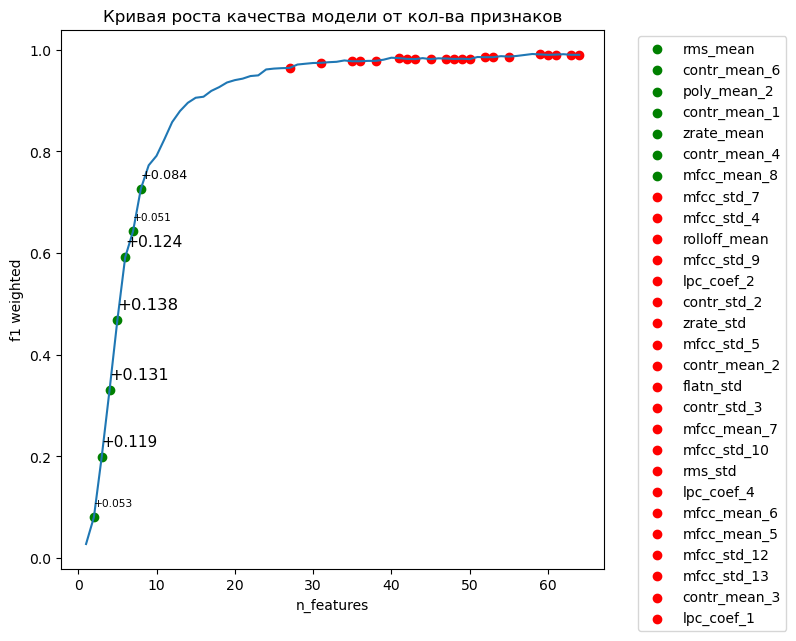

In [611]:
x_axis = list(range(1, len(features_names)+1))
y_axis = scores
labels = imp_list
diff_list = list(np.array(scores)-np.array([0]+scores[:-1]))
diff_list = list(map(lambda x: round(x,3), diff_list))

fig, ax = plt.subplots(figsize=(7,7))

ax.plot(x_axis, y_axis)

for i, diff in enumerate(diff_list):
    if abs(diff)>0.05 or diff<=0:
        c = 'red' if diff<=0 else 'green'
        ax.scatter(x_axis[i], y_axis[i], label=labels[i], c=c)
    if abs(diff)>0.05:
        text = '+' if diff>0 else ''
        text += str(diff)
        ax.annotate(text, (x_axis[i], y_axis[i]), textcoords="offset points", xytext=(0,8), ha='left', fontsize=5+abs(diff)*50)

plt.title('Кривая роста качества модели от кол-ва признаков')
plt.ylabel('f1 weighted')
plt.xlabel('n_features')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Зелеными точками обозначены признаки, дающие наибольшие приросты метрики, а красными - либо не дающие прироста, либо даже ухудшающие метрику признаки.

In [612]:
top_diff_values, top_diff_names = zip(*sorted(zip(diff_list, imp_list)))

In [613]:
score_diff = pd.Series(*zip(*sorted(zip(diff_list, imp_list)))).sort_values(ascending=False)

In [614]:
res = pd.concat([imp, score_diff], axis=1)
res.columns = ['importance', 'score_diff']
res['prod'] = res['importance']*res['score_diff']
res.head(5)

,importance,score_diff,prod
mfcc_mean_1,0.196518,0.028,0.005503
rms_mean,0.092901,0.053,0.004924
contr_mean_6,0.092783,0.119,0.011041
poly_mean_2,0.078888,0.131,0.010334
contr_mean_1,0.077735,0.138,0.010727


prod = importance * score_diff

Топ-10 признаков по prod

In [615]:
print(*res['prod'].sort_values(ascending=False)[:10].index.to_list(), sep='\n')

contr_mean_6
contr_mean_1
poly_mean_2
zrate_mean
mfcc_mean_1
mfcc_mean_8
rms_mean
contr_mean_4
contr_mean_5
mfcc_mean_4


Эти же признаки составляют топ-10 и по значимости, и по приросту метрики

In [616]:
imp_diff_list=list(set(imp[:11].index.to_list())&set(score_diff[:11].index.to_list()))
print(*imp_diff_list, sep='\n')

mfcc_mean_1
zrate_mean
poly_mean_2
mfcc_mean_8
rms_mean
contr_mean_6
lpc_coef_3
contr_mean_1
contr_mean_4
contr_mean_5


Набор признаков, обеспечивающие наибольшее значение метрики

In [617]:
best_f1_index = np.argmax(scores)
best_f1_score = scores[best_f1_index]
best_f1_time = times[best_f1_index]

Набор признаков до "плато" на кривой роста качества модели

In [618]:
before_plateau_index = np.argmax((np.array(scores)-np.array([0]+scores[:-1]))<=0)-1
before_plateau_score = scores[before_plateau_index]
before_plateau_time = times[before_plateau_index]

Набор признаков, лучший по соотношению (значение метрики) / (время обучения)

In [619]:
best_f1_time_index = np.argmax(np.array(scores)/np.array(times))
best_f1_time_score = scores[best_f1_time_index]
best_f1_time_time = times[best_f1_time_index]

Набор признаков, обеспечивающие наименьшее время обучения модели

In [620]:
best_time_index = np.argmin(times)
best_time_score = scores[best_time_index]
best_time_time = times[best_time_index]

In [621]:
dct = {'best_f1_weighted':[best_f1_score, best_f1_index+1, best_f1_time],
       'before_plateau':[before_plateau_score, before_plateau_index+1, before_plateau_time],
       'best_f1_time':[best_f1_time_score, best_f1_time_index+1, best_f1_time_time],
       'best_time':[best_time_score, best_time_index+1, best_time_time]}

Сравнительный датафрейм

In [622]:
summary_df = pd.DataFrame.from_dict(dct, orient='index', columns=['f1_weighted', 'n_features', 'time'])
summary_df

,f1_weighted,n_features,time
best_f1_weighted,0.991565,58,1.982187
before_plateau,0.978904,34,1.301217
best_f1_time,0.961169,24,1.071978
best_time,0.961169,24,1.071978


### Я бы выбрала набор признаков "before_plateau", так как он обеспечивает отличный f1_weighted, слегка жертвуя временем, но в то же время не использует кучу безполезных признаков, на создание, которых тоже тратится время.

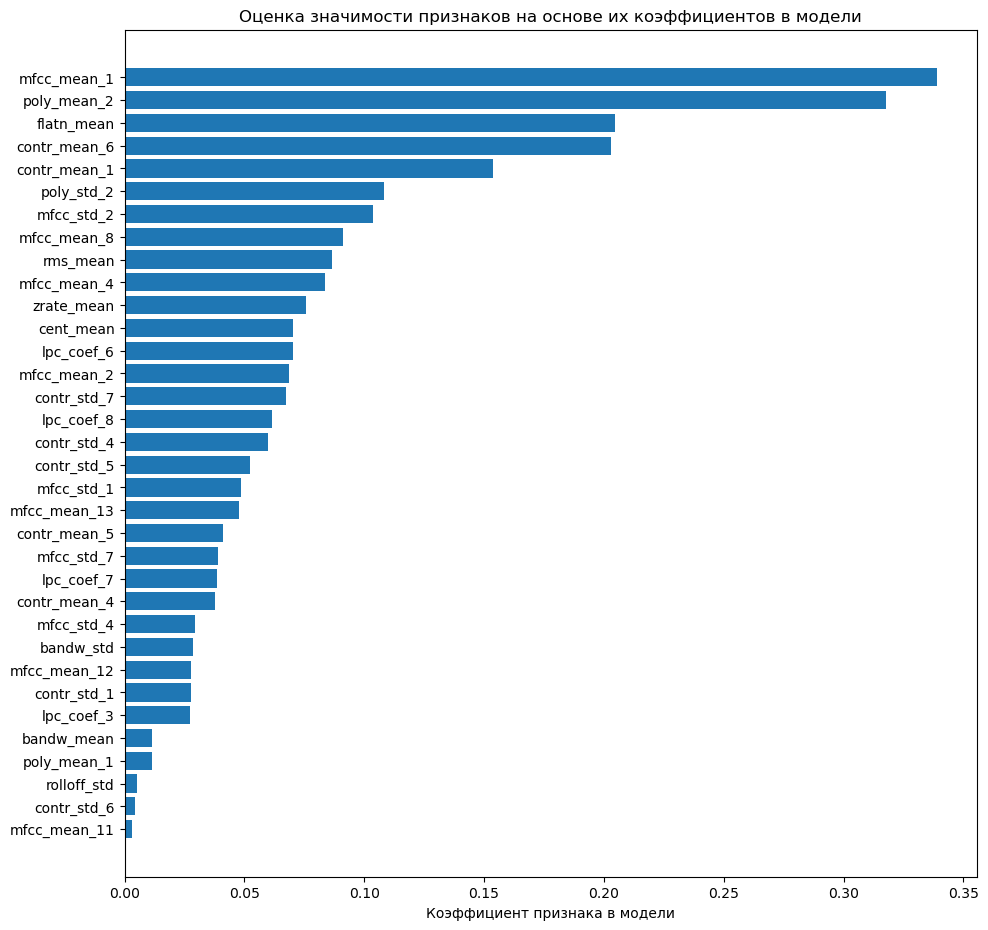

In [632]:
before_plateau = imp_list[:before_plateau_index+1]
clf = make_pipeline(StandardScaler(), LinearSVC(max_iter=10000))
clf.fit(X[before_plateau], y)
f_importances(abs(clf.get_params()['linearsvc'].coef_.mean(axis=0)), before_plateau)

## Вывод: несмотря на то, что для индентификации личности по голосу из всех этих признаков обычно используются только мел-частотные кепстральные коэффициенты, оказалось, что и некоторые другие признаки отлично себя показывают в решении этой задачи, например плоскостность, которая обычно используется для классификации шумов, и контрастность, которая обычно используется для классификации музыки по жанрам.